# True Reach Estimator
We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions.

- Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users.

# The goal:
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business.

## Trial 8

Deleting the comments columns and trying a square root transformation to the data.

In [1]:
# import necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import re

plt.style.use('seaborn')

In [2]:
# import the clean data file
df = pd.read_csv('clean_instagram_train.csv')
df.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach
0,544525,25327,2018-02-23T12:53:16.000+00:00,435,46,5915,4775
1,313043,19247,2017-09-20T00:57:55.000+00:00,274,43,1406,1044
2,489337,3238,2017-11-28T22:12:23.000+00:00,555,28,2789,2234
3,641022,11711,2018-06-03T19:57:38.000+00:00,242,2,4352,3289
4,533712,16598,2018-05-13T23:40:22.000+00:00,170,25,1446,987


## Drop the comments column all together

In [3]:
# drop the first column which are just the indices, dropped the published column, dropped impressions
df.drop(columns= ['impressions','published', 'Unnamed: 0', 'comments'], inplace=True)
df.head()

,followers,likes,reach
0,25327,435,4775
1,19247,274,1044
2,3238,555,2234
3,11711,242,3289
4,16598,170,987


## Create a new dataframe

In [4]:
df_dropcomm= df.copy()

In [5]:
df_dropcomm.shape

(265018, 3)

In [6]:
df_dropcomm.head()

,followers,likes,reach
0,25327,435,4775
1,19247,274,1044
2,3238,555,2234
3,11711,242,3289
4,16598,170,987


## Scatter plot of Followers and Reach, dropped rows where reach was greater than 200,000

In [7]:
df_dropcomm[df_dropcomm.reach>400000].count()

followers    33
likes        33
reach        33
dtype: int64

In [8]:
df_dropcomm.drop(df_dropcomm[df_dropcomm.reach>200000].index, inplace= True)

In [9]:
df_dropcomm.shape

(264889, 3)

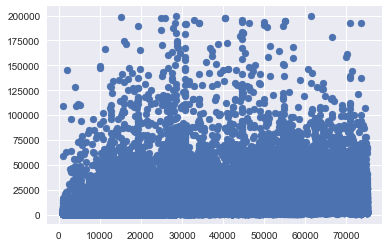

In [10]:
plt.scatter(df_dropcomm['followers'], df_dropcomm['reach']);
# plt.xlim(0,2000)
# plt.ylim(0,700000);

## Scatter plot of Likes and Reach, here we remove outliers that have  'likes' greater than 17,000

In [11]:
df_dropcomm.drop(df_dropcomm[df_dropcomm['likes']>17000].index, inplace=True)

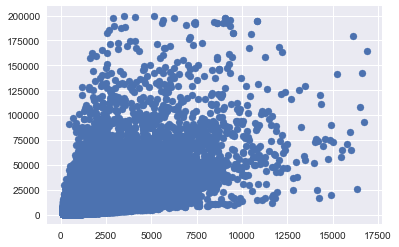

In [12]:
plt.scatter(df_dropcomm['likes'], df_dropcomm['reach']);

In [13]:
df_dropcomm.drop(df_dropcomm[df_dropcomm['reach']==0].index, inplace=True)

In [14]:
import numpy as np

In [15]:
df_dropcomm.head()

,followers,likes,reach
0,25327,435,4775
1,19247,274,1044
2,3238,555,2234
3,11711,242,3289
4,16598,170,987


# Taking a look at the linear regression model excluding comments

In [16]:
lr_modelexcomm = ols(formula='reach~followers + likes', data=df_dropcomm).fit()
lr_modelexcomm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                 1.392e+05
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:10:12   Log-Likelihood:            -2.6834e+06
No. Observations:              264880   AIC:                         5.367e+06
Df Residuals:                  264877   BIC:                         5.367e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -769.3995     19.786    -38.886      0.000    -808.179    -730.620
followers      0.0587      0.001     81.823      0.000       0.057       0.060
likes          6.5412      0.015    427.953      0.000       6.511       6.571
==============================================================================
Omnibus:                   348731.108   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        179815506.732
Skew:                           7.107   Prob(JB):                         0.00
Kurtosis:                     129.848   Cond. No.                     5.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Creating a new column in our dataframe using our regression model from ols

In [17]:
df_dropcomm['predicted_reach']= lr_modelexcomm.predict()

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
mean_squared_error(df_dropcomm.reach, df_dropcomm.predicted_reach)**.5

6074.416304497445

In [20]:
lr_modelexcomm.rsquared

0.5124878727076694

In [21]:
len(df_dropcomm)

264880

In [22]:
"The rsquared of our model excluding comments is {} and our mean-squared error is {}.".format(lr_modelexcomm.rsquared,mean_squared_error(df_dropcomm.reach, df_dropcomm.predicted_reach)**.5)

'The rsquared of our model excluding comments is 0.5124878727076694 and our mean-squared error is 6074.416304497445.'

## The $R^2$ of our model excluding comments is 0.5124878727076694 and our mean-squared error is 6074.416304497445.

# Add a column for squareroot of followers and squareroot of likes

In [23]:
df_dropcomm['followers_sqrt']= df_dropcomm['followers'].apply(lambda x: np.sqrt(x))

In [24]:
df_dropcomm['likes_sqrt']= df_dropcomm['likes'].apply(lambda x: np.sqrt(x))

In [25]:
df_dropcomm.head()

,followers,likes,reach,predicted_reach,followers_sqrt,likes_sqrt
0,25327,435,4775,3562.984669,159.144588,20.856654
1,19247,274,1044,2152.893300,138.733558,16.552945
2,3238,555,2234,3051.053737,56.903427,23.558438
3,11711,242,3289,1501.128756,108.217374,15.556349
4,16598,170,987,1317.086303,128.833226,13.038405


# Creating a linear regression model exluding comments and creating a curvilinear regression using the square root of followers and the squareroot of likes


In [26]:
lr_modelexcomm_sqrt= ols(formula='reach~ followers+ followers_sqrt+ likes_sqrt + likes', data=df_dropcomm).fit()
lr_modelexcomm_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 7.139e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:10:14   Log-Likelihood:            -2.6817e+06
No. Observations:              264880   AIC:                         5.363e+06
Df Residuals:                  264875   BIC:                         5.364e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1093.5290     77.434     14.122      0.000     941.760    1245.298
followers          0.0267      0.003      8.407      0.000       0.020       0.033
followers_sqrt    14.7308      0.999     14.739      0.000      12.772      16.690
likes_sqrt      -199.8756      3.400    -58.779      0.000    -206.540    -193.211
likes              8.9678      0.044    203.778      0.000       8.881       9.054
==============================================================================
Omnibus:                   342954.930   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        178329544.148
Skew:                           6.867   Prob(JB):                         0.00
Kurtosis:                     129.370   Cond. No.                     1.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
df_dropcomm['predicted_reach_sqrt']= lr_modelexcomm_sqrt.predict()

In [28]:
mean_squared_error(df_dropcomm.reach, df_dropcomm.predicted_reach_sqrt)**.5

6035.076063689838

In [29]:
"The rsquared of our model excluding comments and taking the squareroot of our independent variables is {} and our mean-squared error is {}.".format(lr_modelexcomm_sqrt.rsquared,mean_squared_error(df_dropcomm.reach, df_dropcomm.predicted_reach_sqrt)**.5)

'The rsquared of our model excluding comments and taking the squareroot of our independent variables is 0.5187820543257242 and our mean-squared error is 6035.076063689838.'

### The $R^2$ of our model excluding comments and taking the squareroot of our independent variables is 0.5187820543257242 and our mean-squared error is 6035.076063689838.


Doing a square root transformation on our independent variables barely increases our R2 or mean squared error.

## Scatter plot of Sqrt Followers and Reach

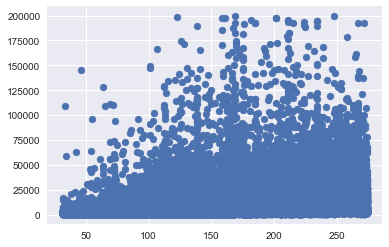

In [30]:
plt.scatter(df_dropcomm['followers_sqrt'], df_dropcomm['reach']);

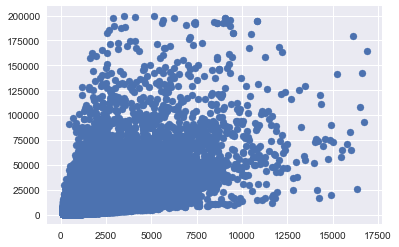

In [31]:
plt.scatter(df_dropcomm['likes'], df_dropcomm['reach']);

In [32]:
df_dropcomm.head()

,followers,likes,reach,predicted_reach,followers_sqrt,likes_sqrt,predicted_reach_sqrt
0,25327,435,4775,3562.984669,159.144588,20.856654,3846.303854
1,19247,274,1044,2152.893300,138.733558,16.552945,2799.699815
2,3238,555,2234,3051.053737,56.903427,23.558438,2286.560384
3,11711,242,3289,1501.128756,108.217374,15.556349,2061.193875
4,16598,170,987,1317.086303,128.833226,13.038405,2352.958319


## Take a look at the interaction between our independent variable and reach

In [33]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()
regression_4 = LinearRegression()

likes = df_dropcomm["likes"].values.reshape(-1, 1)
likes_sqrt = df_dropcomm["likes_sqrt"].values.reshape(-1, 1)
followers_sqrt = df_dropcomm["followers"].values.reshape(-1, 1)
followers = df_dropcomm["followers_sqrt"].values.reshape(-1, 1)

regression_1.fit(likes, df_dropcomm["reach"])
regression_2.fit(followers_sqrt, df_dropcomm["reach"])
regression_3.fit(followers, df_dropcomm["reach"])
regression_4.fit(likes_sqrt, df_dropcomm["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(followers_sqrt)
pred_3 = regression_3.predict(followers)
pred_4 = regression_4.predict(likes_sqrt)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)
print(regression_4.coef_)



[7.10671424]
[0.19757029]
[60.81730752]
[488.80227863]


## Creating Scatter plots of our new data

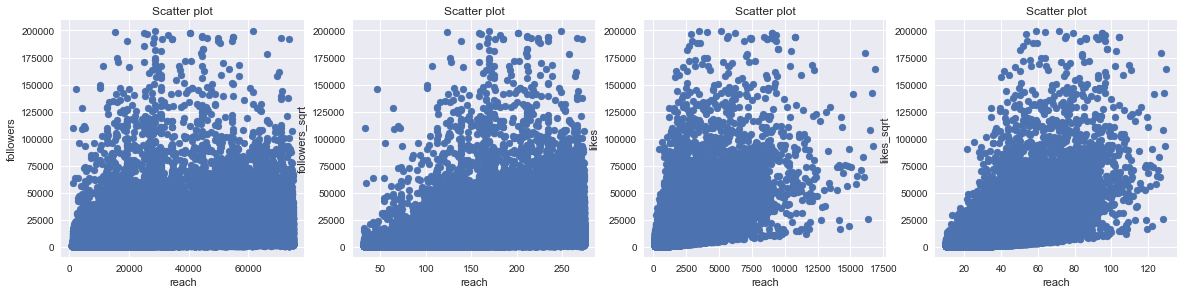

In [34]:
fig = plt.figure(figsize=[20,20])

ax1 = fig.add_subplot(441)
ax1.scatter(df_dropcomm.followers, df_dropcomm.reach)
ax1.set_xlabel('reach')
ax1.set_ylabel('followers')
ax1.set_title("Scatter plot")

ax2 = fig.add_subplot(442)
ax2.scatter(df_dropcomm.followers_sqrt, df_dropcomm.reach)
ax2.set_xlabel('reach')
ax2.set_ylabel('followers_sqrt')
ax2.set_title("Scatter plot")

ax3 = fig.add_subplot(443)
ax3.scatter(df_dropcomm.likes, df_dropcomm.reach)
ax3.set_xlabel('reach')
ax3.set_ylabel('likes')
ax3.set_title("Scatter plot")

ax4 = fig.add_subplot(444)
ax4.scatter(df_dropcomm.likes_sqrt, df_dropcomm.reach)
ax4.set_xlabel('reach')
ax4.set_ylabel('likes_sqrt')
ax4.set_title("Scatter plot");

## After running our analysis excluding comments and transforming our independent variables, we determine that this is not our best fitting model based on our $R^2$ and mean squared error value. We still do not have a model that satisfies our goal.